In [49]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../python_tools')
import tools
import os
from glob import glob

In [50]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
import parcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle,ScipyParticle,Field, AdvectionRK4_3D, AdvectionRK4,BrownianMotion2D, OutOfBoundsError,  KernelError,plotTrajectoriesFile,random

In [32]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta, datetime
from operator import attrgetter

In [33]:
#sys.path.append('/home/jovyan/LOCALDATA/notebooks/parcels/parcels/kernels/')

# Testing Parcels

Two drifters were launched during March 2020. Ocean Parcels is here tested. Trajectory of the drifters is simulated using **brownian 2D motion as diffussion** together with **advection RK4 integration**

##### Load kernels for AdvectionRK4, Brownian 2D and Beaching

In [34]:
from advection_diffusion import *

##### Function to load Dataset from local repository

In [35]:
import pendulum
import gc

def get_dataset_period(start_date, end_date):
    remote_data = None
    base_remote_wmop_surface = 'http://thredds.priv.socib.es/thredds/dodsC/operational_models/oceanographical/hydrodynamics/wmop_3d'
    base_remote_wmop_surface = '/mnt/waverider/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_ASSIM/forecast_scratch'
    period = pendulum.period(start_date, end_date)
    for date in period.range('days', 1):
        wmop_file = F"{base_remote_wmop_surface}/{date.year}/{date.month:02}/roms_wmop_3d_{date.year}{date.month:02}{date.day:02}.nc"
        wmop_file = F"{base_remote_wmop_surface}/roms_WMOP_FORECAST_{date.year}{date.month:02}{date.day:02}_his.nc"
        try:
            ds = xr.open_dataset(wmop_file)
            if ds is None:
                print(F"REMOTE NOT FOUND: {wmop_file}")
                continue
            ds = ds[['u', 'v', 's_rho']].isel(ocean_time=slice(0,8), s_rho=[-1])
            if remote_data is None:
                remote_data = ds
            else:
                remote_data = xr.concat([remote_data, ds], 'ocean_time', join='exact')
                
            del ds
            gc.collect()
        except Exception as e:
            print(e)
            pass
    
    
    return remote_data

#### Drifter files Path

In [36]:
drifter_file1 = 'http://thredds.socib.es/thredds/dodsC/drifter/surface_drifter/drifter_svpb007-scb_svpb007/L1/2020/dep0001_drifter-svpb007_scb-svpb007_L1_2020-03-12.nc'
drifter_file2 = 'http://thredds.socib.es/thredds/dodsC/drifter/surface_drifter/drifter_svpb006-scb_svpb006/L1/2020/dep0001_drifter-svpb006_scb-svpb006_L1_2020-03-12.nc'

##### Some particle parameters

In [37]:
particles_n = 50
dt = timedelta(minutes=30)
integration_time = timedelta(hours=24*3)
output_dt = timedelta(minutes=60)
ND = 1000



#### Function: generate_initial_position_particles

In [46]:
def generate_initial_position_particles(lons, lats, ND, diffussion=True):
    
    if diffussion == True:
        # Create arrays for initial position particles
        lon0 = np.repeat(lons,ND)
        lat0 = np.repeat(lats,ND)
        
    else:
        inc_mag=0.01
        lat0 = []
        lon0 = []
        for i in range(len(lats)):
            lat = [lats[i]-(np.random.rand()*inc_mag) for n in range(ND)]
            lon = [lons[i]+(np.random.rand()*inc_mag) for n in range(ND)]
            lat0 = lat0 + lat
            lon0 = lon0 + lon
        lat0 = np.array(lat0)
        lon0 = np.array(lon0)
            
    depths = lat0*0
    
    return lon0, lat0, depths

##### Create new particle class

In [39]:
class PlasticParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)
    # beached : 0 sea, 1 beached, 2 after non-beach dyn, 3 after beach dyn, 4 please unbeach
    beached = Variable('beached', dtype=np.int32, initial=0.)
    unbeachCount = Variable('unbeachCount', dtype=np.int32, initial=0.)

## Launch Simulation

- 3 days lagrangian simulation
- WMOP ASSIM his fields are used from waverider
- Each day 2000 particles launched. 1000 at the position of the drifter at 00:00 the initial date
- kernels for AdvectionRK4, Brownian 2D and Beaching included

In [40]:
import time

In [ ]:
drif1 = xr.open_dataset(drifter_file1)
drif2 = xr.open_dataset(drifter_file2)

date = datetime(2020,3,15)


for i in range(12):
    print(date)
    t0_field = time.time()
    
    strdate_ini = date.strftime('%Y%m%d')
    strdate_end = (date + timedelta(days=3) ).strftime('%Y%m%d')
    
    wmop_ds = get_dataset_period(pendulum.parse(strdate_ini), pendulum.parse(strdate_end) )
    
    times = wmop_ds.ocean_time.values.astype(datetime)/10**9
    
    fieldset = FieldSet.from_data(
        {'U':wmop_ds.u.values,'V':wmop_ds.v.values},
        {'U':{'lon':wmop_ds.lon_u.values,'lat':wmop_ds.lat_u.values,'time': times},
         'V':{'lon':wmop_ds.lon_v.values,'lat':wmop_ds.lat_v.values,'time': times}} )

    # diffussion parameters
    kh_zonal = 50 # in m^2/s
    kh_meridional = 50  # in m^2/s

    # Create field of Kh_zonal and Kh_meridional, using same grid as U
    grid = fieldset.U.grid
    fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones(wmop_ds.u.shape), grid=grid))
    fieldset.add_field(Field('Kh_meridional', kh_zonal*np.ones(wmop_ds.u.shape), grid=grid))


    # Subset drifters to selected period
    d1 = drif1.sel(time=slice(date, date + timedelta(days=3)))
    d2 = drif2.sel(time=slice(date, date + timedelta(days=3)))

    # Get Initial position of particles
    lons = [d1.LON[0].values, d2.LON[0].values]
    lats = [d1.LAT[0].values, d2.LAT[0].values]

    # Create arrays for initial position particles
    lon0, lat0, depths = generate_initial_position_particles(lons, lats, ND, diffussion=False)
    
    pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=PlasticParticle,  # the type of particles (JITParticle or ScipyParticle)
                             #time=release_time,
                             lon=lon0, # a vector of release longitudes 
                             lat=lat0,
                             depth=depths)

    #runtime = (end_date - start_date).as_timedelta()
    runtime = timedelta(days=3)
    
    kernel =  pset.Kernel(AdvectionRK42) + pset.Kernel(BeachTesting_2D) #+ pset.Kernel(BrownianMotion2D2) + pset.Kernel(BeachTesting_2D)
    
    
    output_name = F"../../trajectories/wmop_advection_{strdate_ini}_{strdate_end}.nc"
    #output_name = '/home/jovyan/LOCALDATA/trajectories/prueba_difusion12.nc'

    # Execute lagrangian particle simulation  

    pset.execute( kernel,runtime=runtime, dt=dt,
                 output_file=pset.ParticleFile(name=output_name, outputdt=output_dt))


    tf_field = time.time()

    print('Time spent to load Fieldset for 3 days = {0} seconds'.format(tf_field-t0_field))
    
    date = date + timedelta(days=1)
    
    del wmop_ds

2020-03-15 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/15fb55815b81197b144a3b8cc374adb9_0.so


Time spent to load Fieldset for 3 days = 14.918525218963623 seconds
2020-03-16 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/68f2c4e4dcee5209587c6351a74473e3_0.so


Time spent to load Fieldset for 3 days = 15.121938943862915 seconds
2020-03-17 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/10fe7b4e7cbd06db09f790e79db409cd_0.so


Time spent to load Fieldset for 3 days = 16.984389543533325 seconds
2020-03-18 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/ea88c28f9510443d805ffb033f2a6dfd_0.so


Time spent to load Fieldset for 3 days = 17.175409078598022 seconds
2020-03-19 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/53aadd015c1eb4e9446b6164ea29b97a_0.so


Time spent to load Fieldset for 3 days = 17.134928703308105 seconds
2020-03-20 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/6fd31f03e2556fc1e260a8301281a3de_0.so


Time spent to load Fieldset for 3 days = 16.99747347831726 seconds
2020-03-21 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/9307b7c19870c253f7d957ca66e6ecf7_0.so


Time spent to load Fieldset for 3 days = 17.117132663726807 seconds
2020-03-22 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2D ==> /tmp/parcels-22478/e5cdaf9c91d50a4a51ae907b50c8b9a2_0.so


## Plot Particles

In [51]:
part_files = sorted(glob('../../trajectories/wmop_advection_2*.nc'), key=os.path.getmtime)

In [52]:
part_files

['../../trajectories/wmop_advection_20200315_20200318.nc',
 '../../trajectories/wmop_advection_20200316_20200319.nc',
 '../../trajectories/wmop_advection_20200317_20200320.nc',
 '../../trajectories/wmop_advection_20200318_20200321.nc',
 '../../trajectories/wmop_advection_20200319_20200322.nc',
 '../../trajectories/wmop_advection_20200320_20200323.nc',
 '../../trajectories/wmop_advection_20200321_20200324.nc',
 '../../trajectories/wmop_advection_20200322_20200325.nc',
 '../../trajectories/wmop_advection_20200323_20200326.nc',
 '../../trajectories/wmop_advection_20200324_20200327.nc',
 '../../trajectories/wmop_advection_20200325_20200328.nc',
 '../../trajectories/wmop_advection_20200326_20200329.nc']

2020-03-15 00:00:00


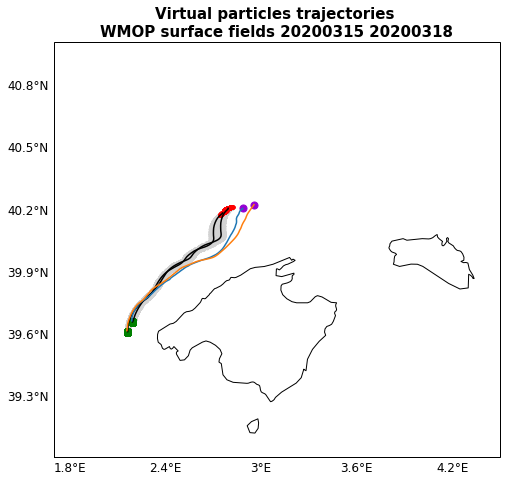

2020-03-16 00:00:00


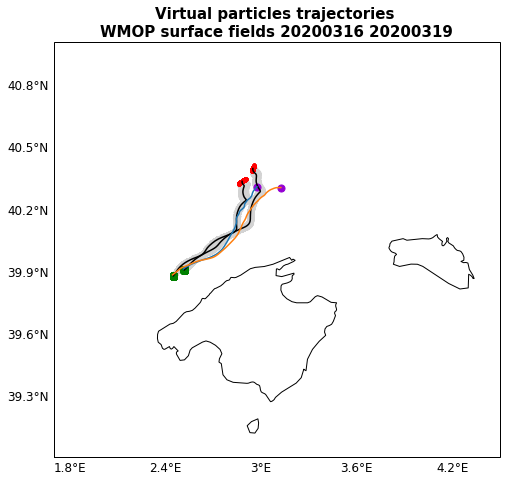

2020-03-17 00:00:00


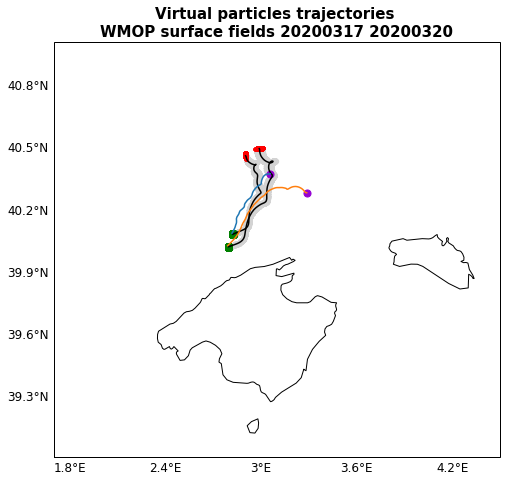

2020-03-18 00:00:00


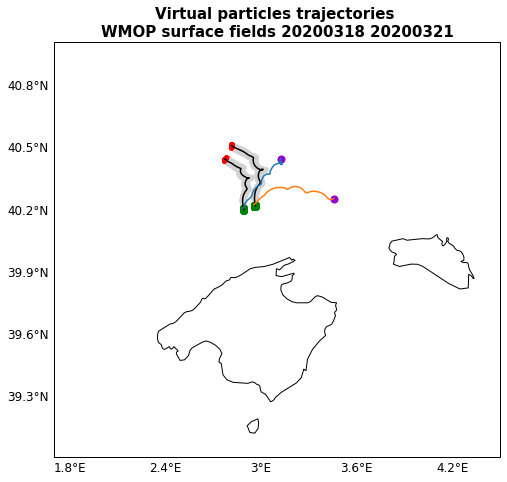

2020-03-19 00:00:00


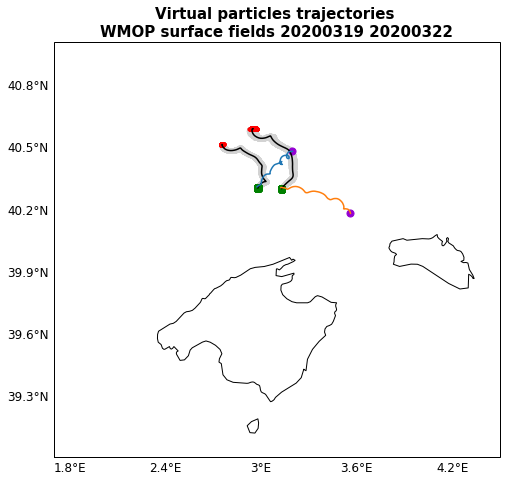

2020-03-20 00:00:00


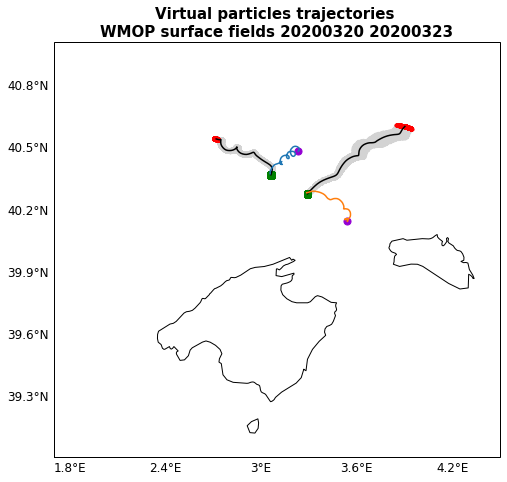

2020-03-21 00:00:00


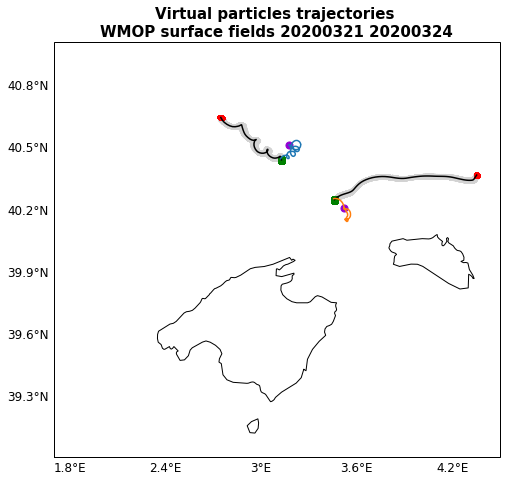

2020-03-22 00:00:00


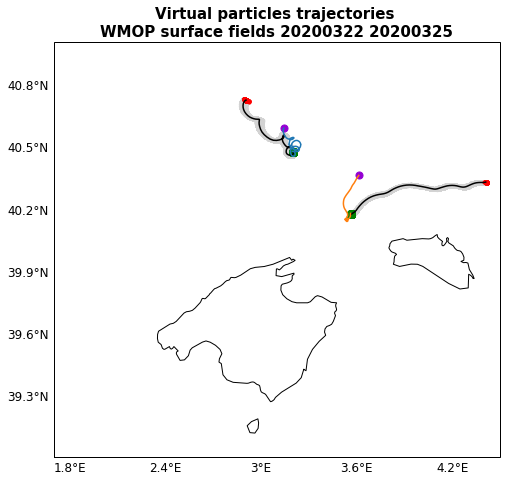

2020-03-23 00:00:00


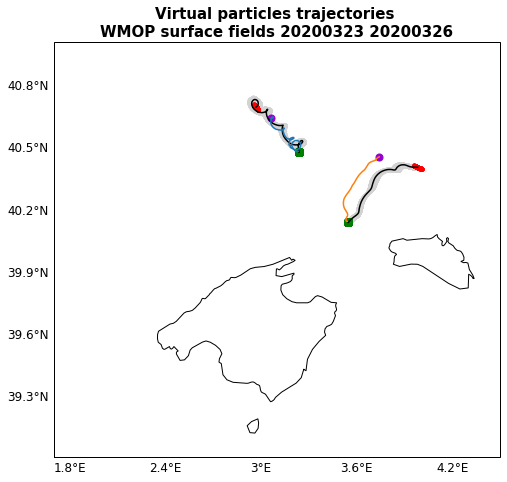

2020-03-24 00:00:00


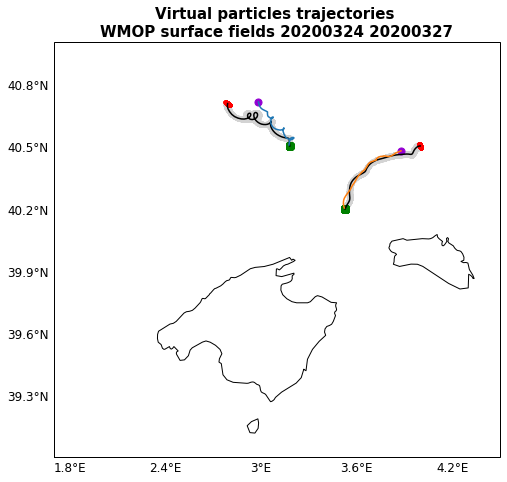

2020-03-25 00:00:00


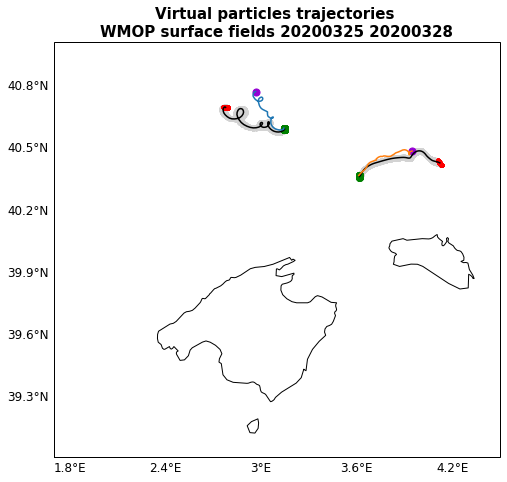

2020-03-26 00:00:00


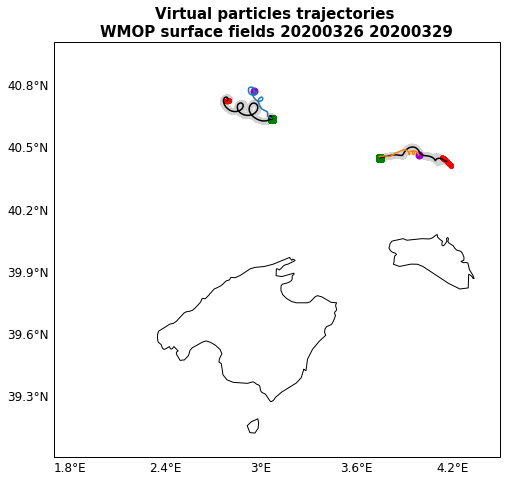

In [57]:
date = datetime(2020,3,15)


for i in range(12):
    print(date)

    strdate_ini = date.strftime('%Y%m%d')
    strdate_end = (date + timedelta(days=3) ).strftime('%Y%m%d')
    
    # Subset drifters to selected period
    d1 = drif1.sel(time=slice(date, date + timedelta(days=3)))
    d2 = drif2.sel(time=slice(date, date + timedelta(days=3)))
    
    parcels_file = F"../../trajectories/wmop_advection_{strdate_ini}_{strdate_end}.nc"
    part = xr.open_dataset(parcels_file)
    
    fig = plt.figure(figsize=(8,8))
    ax,gl = tools.make_map(continents=False, limits=[1.7,4.5,39.0,41]) 

    plt.scatter(part.lon, part.lat, 5, 'lightgrey', transform=gl.crs)
    plt.scatter(part.lon[:,-1], part.lat[:,-1], 10, 'r', transform=gl.crs)
    plt.scatter(part.lon[:,0], part.lat[:,0], 30, 'green', transform=gl.crs)
    plt.plot(np.mean(part.lon[:1000,:],axis=0), np.mean(part.lat[:1000,:], axis=0), 'k', transform=gl.crs)
    plt.plot(np.mean(part.lon[1000:,:],axis=0), np.mean(part.lat[1000:,:], axis=0), 'k', transform=gl.crs)
    
    # Plot Drifters
    
    plt.plot(d1.LON, d1.LAT, 5, 'darkblue', transform=gl.crs)
    plt.scatter(d1.LON[-1], d1.LAT[-1], 50, 'darkviolet', transform=gl.crs)
    plt.plot(d2.LON, d2.LAT, 5, 'darkblue', transform=gl.crs)
    plt.scatter(d2.LON[-1], d2.LAT[-1], 50, 'darkviolet', transform=gl.crs)
    
    plt.title(F"Virtual particles trajectories \nWMOP surface fields {strdate_ini} {strdate_end}", fontsize=15, fontweight='bold')
    
    plot_path = '/LOCALDATA/Dropbox/SOCIB/trajectories_plots/Mallorca_drifters_Apr2020'
    fig.savefig(F"{plot_path}/wmop_advection_{strdate_ini}_{strdate_end}.png", dpi=250)
    
    plt.show()
    
    date = date + timedelta(days=1)
    